# Goal driven error estimator:
## Geometry of examples:
Geometry where all goal areas and subdomains are resolved.

In [1]:
import ngsolve as ngs
from ngsolve.webgui import Draw
maxh = 1
import matplotlib.pyplot as plt
import numpy as np

from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
cos = [(0.7,0.45), (0.75,0.45), (0.8,0.45), (0.8, 0.55), (0.75,0.55), (0.7,0.55), (0.75,0.5)]
for co in cos:
    geo.AddPoint(*co)
geo.Append(["line", 0,1], leftdomain=3, rightdomain=1, bc='none'  , maxh=maxh)
geo.Append(["line", 1,6], leftdomain=3, rightdomain=3, bc='goal_2', maxh=maxh)
geo.Append(["line", 6,4], leftdomain=3, rightdomain=3, bc='goal_2', maxh=maxh)
geo.Append(["line", 4,5], leftdomain=3, rightdomain=1, bc='none'  , maxh=maxh)
geo.Append(["line", 5,0], leftdomain=3, rightdomain=1, bc='none'  , maxh=maxh)
geo.Append(["line", 1,2], leftdomain=3, rightdomain=1, bc='none'  , maxh=maxh)
geo.Append(["line", 2,3], leftdomain=3, rightdomain=1, bc='none'  , maxh=maxh)
geo.Append(["line", 3,4], leftdomain=3, rightdomain=1, bc='none'  , maxh=maxh)
geo.AddRectangle( (0,0), (1,1), leftdomain=1, rightdomain=0, bc='outer')
geo.AddRectangle( (0.2,0.45), (0.3,0.55), leftdomain=2, rightdomain=1,maxh=0.05, 
                 bcs=['inner_bot', 'inner_right', 'inner_top', 'inner_left'])
geo.SetMaterial(1, 'outer')
geo.SetMaterial(2, 'source')
geo.SetMaterial(3, 'goal_1')

#mesh = ngs.Mesh(geo.GenerateMesh(maxh = maxh))
mesh = ngs.Mesh("mesh_bsp30.vol")
Draw(ngs.CoefficientFunction( [1,2,3] ), mesh, "domains")

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

In [2]:
order = 2

#Referenzwerte aus PDF
ref_1 = 0.042556207995730
ref_2 = 0.042349426604237
ref_3 = 0.042557119266960

## Erstellen der FES und Gridfunctions für Lösung $u$ sowie $\eta_{zz}$ und Lösungen $w$ der dualen Probleme 

In [3]:
fes = ngs.H1(mesh, order = order , dirichlet = "outer")
fe_ag = ngs.VectorH1(mesh, order = order, dirichlet = "outer")

u_approx = ngs.GridFunction(fes)
u_approx_grad_avg = ngs.GridFunction(fe_ag)

w_1_approx = ngs.GridFunction(fes)
w_1_approx_grad_avg = ngs.GridFunction(fe_ag)

w_2_approx = ngs.GridFunction(fes)
w_2_approx_grad_avg = ngs.GridFunction(fe_ag)

w_3_approx = ngs.GridFunction(fes)
w_3_approx_grad_avg = ngs.GridFunction(fe_ag)

## Aufstellen der Bilinear- sowie Linearform



In [4]:
u = fes.TrialFunction()
v = fes.TestFunction()

a = ngs.BilinearForm(fes, symmetric = True)
a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
a.Assemble()

f = ngs.LinearForm(fes)
f += 100 * v * ngs.dx("source")
f.Assemble()

In [5]:
u_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec

Draw(u_approx, mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

## Implementierung der Linearformen $b_i, i \in \{1,2,3\}$

In [6]:
b_1 = ngs.LinearForm(fes)
b_1 += 100 * v * ngs.dx("goal_1")
b_1.Assemble()


b_2 = ngs.LinearForm(fes)
b_2 += 10 * v * ngs.ds("goal_2")
b_2.Assemble()

b_3 = ngs.LinearForm(fes)
b_3 += v(0.75, 0.5)
b_3.Assemble()

## Lösen der dualen Probleme

In [7]:
w_1_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_1.vec
w_2_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_2.vec
w_3_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_3.vec

## Fehler beim Verfeinern der Ordnung

Zuerst wird hier nur die Ordnung vergrößert um zu sehen, wie sich die Approximation bei gleichbleibendem Mesh verbessert.

In [8]:
order_arr = [i for i in range(1,7)]

#Fehlerarrays für "exakte" Fehler
w_1_err = []
w_2_err = []
w_3_err = []


#Fehlerschätzer-Arrays
eta_ZZ_arr = []

eta_ZZ_1_arr = []
eta_ZZ_2_arr = []
eta_ZZ_3_arr = []

for order in order_arr:
    fes = ngs.H1(mesh, order = order , dirichlet = "outer")
    fe_ag = ngs.VectorH1(mesh, order = order, dirichlet = "outer")

    #Lösungsfunktion der PDE
    u_approx = ngs.GridFunction(fes)
    
    #zur späteren Interpolation für Fehlerschätzer
    u_approx_grad_avg = ngs.GridFunction(fe_ag)    
    
    #Lösungsfunktion von (4)
    w_1_approx = ngs.GridFunction(fes)
    
    #zur späteren Interpolation für Fehlerschätzer
    w_1_approx_grad_avg = ngs.GridFunction(fe_ag)  
    
    #ebendies
    w_2_approx = ngs.GridFunction(fes)          
    w_2_approx_grad_avg = ngs.GridFunction(fe_ag)
    
    w_3_approx = ngs.GridFunction(fes)
    w_3_approx_grad_avg = ngs.GridFunction(fe_ag)
    
    #It's TnT
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    #Aufstellen der Bilinearform
    a = ngs.BilinearForm(fes, symmetric = True)
    a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
    a.Assemble()
    
    #Aufstellen der Linearform
    f = ngs.LinearForm(fes)
    f += 100 * v * ngs.dx("source")
    f.Assemble()
    
    #Lösen des Problems
    u_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
    
    #Aufstellen der b-Linearformen
    b_1 = ngs.LinearForm(fes)
    b_1 += 100 * v * ngs.dx("goal_1")
    b_1.Assemble()

    b_2 = ngs.LinearForm(fes)
    b_2 += 10 * v * ngs.ds("goal_2")
    b_2.Assemble()

    b_3 = ngs.LinearForm(fes)
    b_3 += v(0.75, 0.5)
    b_3.Assemble()
    
    #Fehler von (2) mit Referenzwerten
    w_1_err.append(abs(ngs.InnerProduct(b_1.vec, u_approx.vec)-ref_1))
    w_2_err.append(abs(ngs.InnerProduct(b_2.vec, u_approx.vec)-ref_2))
    w_3_err.append(abs(ngs.InnerProduct(b_3.vec, u_approx.vec)-ref_3))
    
    #Lösen von (4)
    w_1_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_1.vec
    w_2_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_2.vec
    w_3_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_3.vec
    
    #Interpolieren für Fehlerschätzer
    flux = ngs.grad(u_approx)
    u_approx_grad_avg.Set(flux)
    
    flux_1 = ngs.grad(w_1_approx)
    w_1_approx_grad_avg.Set(flux_1)
    flux_2 = ngs.grad(w_2_approx)
    w_2_approx_grad_avg.Set(flux_2)
    flux_3 = ngs.grad(w_3_approx)
    w_3_approx_grad_avg.Set(flux_3)
    
    #viele Fehlerschätzer
    eta_ZZ_arr.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(u_approx) - u_approx_grad_avg,
                    ngs.grad(u_approx) - u_approx_grad_avg),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )
    
    eta_ZZ_1_arr.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(w_1_approx) - w_1_approx_grad_avg,
                    ngs.grad(w_1_approx) - w_1_approx_grad_avg),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )
    
    eta_ZZ_2_arr.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(w_2_approx) - w_2_approx_grad_avg,
                    ngs.grad(w_2_approx) - w_2_approx_grad_avg),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )
    
    eta_ZZ_3_arr.append(
        ngs.sqrt(
            ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(w_3_approx) - w_3_approx_grad_avg,
                    ngs.grad(w_3_approx) - w_3_approx_grad_avg),
                mesh,
                ngs.VOL,
                order * 2
            )
        )
    )

## Fehlerschätzer wie in (6)


In [9]:
for i in range(len(eta_ZZ_arr)):
    eta_ZZ_1_arr[i] = eta_ZZ_arr[i]*eta_ZZ_1_arr[i]
    eta_ZZ_2_arr[i] = eta_ZZ_arr[i]*eta_ZZ_2_arr[i]
    eta_ZZ_3_arr[i] = eta_ZZ_arr[i]*eta_ZZ_3_arr[i]

## Plots!

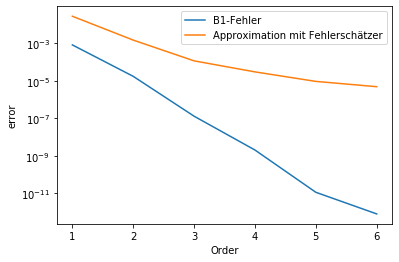

In [10]:
#%matplotlib notebook

#Fehler nach Referenz
plt.semilogy(order_arr, w_1_err, label = "B1-Fehler")
#Fehler nach Fehlerschätzer
plt.semilogy(order_arr, eta_ZZ_1_arr, label = "Approximation mit Fehlerschätzer")

plt.xlabel("Order")
plt.ylabel("error")
plt.legend()
plt.show()

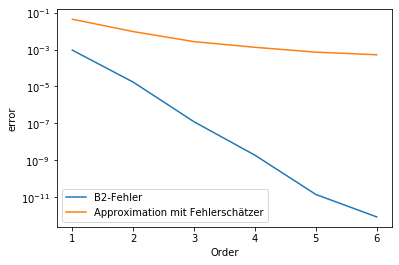

In [11]:
#%matplotlib notebook

#Fehler nach Referenz
plt.semilogy(order_arr, w_2_err, label = "B2-Fehler")
#Fehler nach Fehlerschätzer
plt.semilogy(order_arr, eta_ZZ_2_arr, label = "Approximation mit Fehlerschätzer")

plt.xlabel("Order")
plt.ylabel("error")
plt.legend()
plt.show()

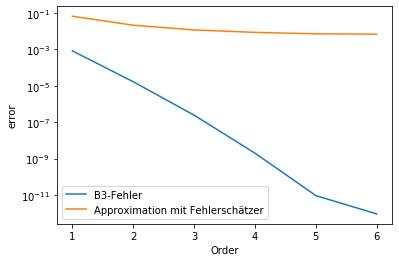

In [12]:
#%matplotlib notebook

#Fehler nach Referenz
plt.semilogy(order_arr, w_3_err, label = "B3-Fehler")
#Fehler nach Fehlerschätzer
plt.semilogy(order_arr, eta_ZZ_3_arr, label = "Approximation mit Fehlerschätzer")

plt.xlabel("Order")
plt.ylabel("error")
plt.legend()
plt.show()

Erhöhen der Ordnung verringert zwar den echten Fehler, die Fehlerschätzer werden dabei nur marginal besser. Das könnte daran liegen, dass die Interpolation im Fehlerschätzer immer linear ist.

In [13]:
order = 4
tol = 1e-10
theta = 0.25

In [25]:
#Fehlerarrays für "exakte" Fehler
u_err = []


#Fehlerschätzer-Arrays

eta_ZZ_1_arr = []
norm = 1
j = 0
#ndof array
ndof_arr = []
while norm > tol:
    fes = ngs.H1(mesh, order = order , dirichlet = "outer")
    fe_ag = ngs.VectorH1(mesh, order = order, dirichlet = "outer")
    
    ndof_arr.append(fes.ndof)

    u_approx = ngs.GridFunction(fes, autoupdate = True)
    u_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)

    w_1_approx = ngs.GridFunction(fes, autoupdate = True)
    w_1_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)
  
    #It's TnT
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    #Aufstellen der Bilinearform
    a = ngs.BilinearForm(fes, symmetric = True)
    a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
    a.Assemble()
    
    #Aufstellen der Linearform
    f = ngs.LinearForm(fes)
    f += 100 * v * ngs.dx("source")
    f.Assemble()
    
    #Lösen des Problems
    u_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
    
    #Aufstellen der b-Linearformen
    b_1 = ngs.LinearForm(fes)
    b_1 += 100 * v * ngs.dx("goal_1")
    b_1.Assemble()

    #Fehler von (2) mit Referenzwerten
    u_err.append(abs(ngs.InnerProduct(b_1.vec, u_approx.vec)-ref_1))
 
    
    w_1_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_1.vec
  
    
    #Interpolieren für Fehlerschätzer
    flux = ngs.grad(u_approx)
    u_approx_grad_avg.Set(flux)
    
    flux_1 = ngs.grad(w_1_approx)
    w_1_approx_grad_avg.Set(flux_1)

    
    #Fehlerschätzer
    
    eta_1 =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(w_1_approx) - w_1_approx_grad_avg,
                    ngs.grad(w_1_approx) - w_1_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
    
    eta_2 =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(u_approx) - u_approx_grad_avg,
                    ngs.grad(u_approx) - u_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
        
    
    eta_num_1 = eta_1.NumPy()                       #Numpy-Array mit Elementbasierten Fehlern
    eta_num_2 = eta_2.NumPy()
    eta_num = eta_num_1*eta_num_2
    
    errnr = []                                  #Liste der Indizes der Mesh-Elemente
    sum1 = 0                                    #Summe aller Fehler
    for el in mesh.Elements():
        errnr.append([eta_num[el.nr],el.nr])    #Fügen Fehler der Mesh-Elemente kodiert mit ihrer Nummer zusammen
        sum1 += eta_num[el.nr]                  #Summieren der Fehler
        
    errnr.sort(key = lambda x: x[0], reverse = True) #Fehler wird absteigend sortiert
    
    sum2 = 0                                    #Teilsumme der Fehler
    i = 0
    refinement_arr = []                         #Indizes der Mesh-Elemente, die refined werden sollen
    while sum2 < sum1*theta:                    #Summiere bis Teilsumme größer als theta*Gesamtsumme, Negation von (4.54)
        sum2 += errnr[i][0]                     #Teilsumme um den i-t größten Fehler erhöhen 
        refinement_arr.append(errnr[i][1])      #Schlüssel an refinement_arr übergeben
        i += 1
    
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el,el.nr in refinement_arr)     #Markieren der Elemente deren Schlüssel im refinement_arr vorkommt

    
    mesh.Refine()                              #Mesh wird verfeinert
    
    if j%3==0:
        Draw(mesh)
    #a.Assemble()                               #Für neuen FES werden Linear- sowie Bilinearform neu Assembliert
    #f.Assemble()
    
    j+=1
    eta_num = np.sqrt(eta_num)                  #Wurzelziehen von eta
    norm = np.linalg.norm(eta_num)
    eta_ZZ_1_arr.append(norm)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

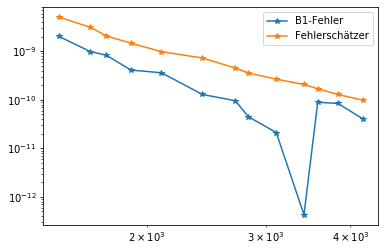

In [15]:
#%matplotlib notebook

plt.loglog(ndof_arr, u_err,"-*", label = "B1-Fehler")
plt.loglog(ndof_arr, eta_ZZ_1_arr, "-*", label = "Fehlerschätzer")

plt.legend()
plt.show()

In [24]:
mesh = ngs.Mesh("mesh_bsp30.vol") #Mesh reset, ansonsten wird am schon verfeinerten mesh weitergearbeitet

In [17]:
#Fehlerarrays für "exakte" Fehler
u_err = []


#Fehlerschätzer-Arrays

eta_ZZ_2_arr = []
norm = 1
j = 0
#ndof array
ndof_arr = []
while norm > tol:
    fes = ngs.H1(mesh, order = order , dirichlet = "outer")
    fe_ag = ngs.VectorH1(mesh, order = order, dirichlet = "outer")
    
    ndof_arr.append(fes.ndof)

    u_approx = ngs.GridFunction(fes, autoupdate = True)
    u_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)

    w_2_approx = ngs.GridFunction(fes, autoupdate = True)
    w_2_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)
  
    #It's TnT
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    #Aufstellen der Bilinearform
    a = ngs.BilinearForm(fes, symmetric = True)
    a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
    a.Assemble()
    
    #Aufstellen der Linearform
    f = ngs.LinearForm(fes)
    f += 100 * v * ngs.dx("source")
    f.Assemble()
    
    #Lösen des Problems
    u_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
    
    #Aufstellen der b-Linearformen
    b_2 = ngs.LinearForm(fes)
    b_2 += 10 * v * ngs.ds("goal_2")
    b_2.Assemble()

    #Fehler von (2) mit Referenzwerten
    u_err.append(abs(ngs.InnerProduct(b_2.vec, u_approx.vec)-ref_2))
 
    
    w_2_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_2.vec
  
    
    #Interpolieren für Fehlerschätzer
    flux = ngs.grad(u_approx)
    u_approx_grad_avg.Set(flux)
    
    flux_1 = ngs.grad(w_2_approx)
    w_2_approx_grad_avg.Set(flux_1)

    
    #Fehlerschätzer
    
    eta_1 =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(w_2_approx) - w_2_approx_grad_avg,
                    ngs.grad(w_2_approx) - w_2_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
    
    eta_2 =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(u_approx) - u_approx_grad_avg,
                    ngs.grad(u_approx) - u_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
        
    
    eta_num_1 = eta_1.NumPy()                       #Numpy-Array mit Elementbasierten Fehlern
    eta_num_2 = eta_2.NumPy()
    eta_num = eta_num_1*eta_num_2
    
    errnr = []                                  #Liste der Indizes der Mesh-Elemente
    sum1 = 0                                    #Summe aller Fehler
    for el in mesh.Elements():
        errnr.append([eta_num[el.nr],el.nr])    #Fügen Fehler der Mesh-Elemente kodiert mit ihrer Nummer zusammen
        sum1 += eta_num[el.nr]                  #Summieren der Fehler
        
    errnr.sort(key = lambda x: x[0], reverse = True) #Fehler wird absteigend sortiert
    
    sum2 = 0                                    #Teilsumme der Fehler
    i = 0
    refinement_arr = []                         #Indizes der Mesh-Elemente, die refined werden sollen
    while sum2 < sum1*theta:                    #Summiere bis Teilsumme größer als theta*Gesamtsumme, Negation von (4.54)
        sum2 += errnr[i][0]                     #Teilsumme um den i-t größten Fehler erhöhen 
        refinement_arr.append(errnr[i][1])      #Schlüssel an refinement_arr übergeben
        i += 1
    
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el,el.nr in refinement_arr)     #Markieren der Elemente deren Schlüssel im refinement_arr vorkommt

    
    mesh.Refine()                              #Mesh wird verfeinert
    
    if j%3==0:
        Draw(mesh)
    #a.Assemble()                               #Für neuen FES werden Linear- sowie Bilinearform neu Assembliert
    #f.Assemble()
    eta_num = np.sqrt(eta_num)                  #Wurzelziehen von eta
    j+=1
    norm = np.linalg.norm(eta_num)
    eta_ZZ_2_arr.append(norm)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

###### Die Mesh-Verfeinerungen finden hier hauptsächlich im Gebiet rund um die Kante, über die $b_2$ integriert, statt.

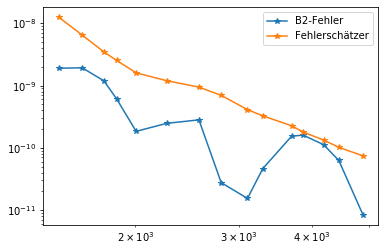

In [18]:
#%matplotlib notebook

plt.loglog(ndof_arr, u_err, "-*", label = "B2-Fehler")
plt.loglog(ndof_arr, eta_ZZ_2_arr, "*-", label = "Fehlerschätzer")

plt.legend()
plt.show()

In [19]:
mesh = ngs.Mesh("mesh_bsp30.vol") #Mesh reset, ansonsten wird am schon verfeinerten mesh weitergearbeitet

In [20]:
#Fehlerarrays für "exakte" Fehler
u_err = []


#Fehlerschätzer-Arrays

eta_ZZ_3_arr = []
norm = 1
j = 0
#ndof array
ndof_arr = []
while norm > tol:
    fes = ngs.H1(mesh, order = order , dirichlet = "outer")
    fe_ag = ngs.VectorH1(mesh, order = order, dirichlet = "outer")
    
    ndof_arr.append(fes.ndof)

    u_approx = ngs.GridFunction(fes, autoupdate = True)
    u_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)

    w_3_approx = ngs.GridFunction(fes, autoupdate = True)
    w_3_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)
  
    #It's TnT
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    #Aufstellen der Bilinearform
    a = ngs.BilinearForm(fes, symmetric = True)
    a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
    a.Assemble()
    
    #Aufstellen der Linearform
    f = ngs.LinearForm(fes)
    f += 100 * v * ngs.dx("source")
    f.Assemble()
    
    #Lösen des Problems
    u_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
    
    #Aufstellen der b-Linearformen
    b_3 = ngs.LinearForm(fes)
    b_3 += v(0.75, 0.5)
    b_3.Assemble()

    #Fehler von (2) mit Referenzwerten
    u_err.append(abs(ngs.InnerProduct(b_3.vec, u_approx.vec)-ref_3))
 
    
    w_3_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * b_3.vec
  
    
    #Interpolieren für Fehlerschätzer
    flux = ngs.grad(u_approx)
    u_approx_grad_avg.Set(flux)
    
    flux_1 = ngs.grad(w_3_approx)
    w_3_approx_grad_avg.Set(flux_1)

    
    #Fehlerschätzer
    
    eta_1 =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(w_3_approx) - w_3_approx_grad_avg,
                    ngs.grad(w_3_approx) - w_3_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
    
    eta_2 =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(u_approx) - u_approx_grad_avg,
                    ngs.grad(u_approx) - u_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
        
    
    eta_num_1 = eta_1.NumPy()                       #Numpy-Array mit Elementbasierten Fehlern
    eta_num_2 = eta_2.NumPy()
    eta_num = eta_num_1*eta_num_2
    
    errnr = []                                  #Liste der Indizes der Mesh-Elemente
    sum1 = 0                                    #Summe aller Fehler
    for el in mesh.Elements():
        errnr.append([eta_num[el.nr],el.nr])    #Fügen Fehler der Mesh-Elemente kodiert mit ihrer Nummer zusammen
        sum1 += eta_num[el.nr]                  #Summieren der Fehler
        
    errnr.sort(key = lambda x: x[0], reverse = True) #Fehler wird absteigend sortiert
    
    sum2 = 0                                    #Teilsumme der Fehler
    i = 0
    refinement_arr = []                         #Indizes der Mesh-Elemente, die refined werden sollen
    while sum2 < sum1*theta:                    #Summiere bis Teilsumme größer als theta*Gesamtsumme, Negation von (4.54)
        sum2 += errnr[i][0]                     #Teilsumme um den i-t größten Fehler erhöhen 
        refinement_arr.append(errnr[i][1])      #Schlüssel an refinement_arr übergeben
        i += 1
    
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el,el.nr in refinement_arr)     #Markieren der Elemente deren Schlüssel im refinement_arr vorkommt

    
    mesh.Refine()                              #Mesh wird verfeinert
    
    if j%3==0:
        Draw(mesh)
    #a.Assemble()                               #Für neuen FES werden Linear- sowie Bilinearform neu Assembliert
    #f.Assemble()
    eta_num = np.sqrt(eta_num)                  #Wurzelziehen von eta
    j+=1
    norm = np.linalg.norm(eta_num)
    eta_ZZ_3_arr.append(norm)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

Auch hier: Hauptsächlich lokale Verfeinerungen rund um (0.75,0.5)

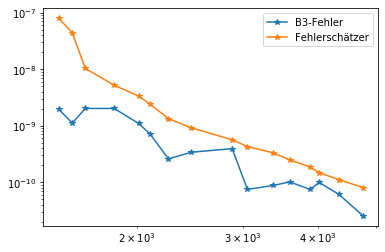

In [21]:
#%matplotlib notebook

plt.loglog(ndof_arr, u_err, "-*", label = "B3-Fehler")
plt.loglog(ndof_arr, eta_ZZ_3_arr, "*-", label = "Fehlerschätzer")

plt.legend()
plt.show()

In [22]:
mesh = ngs.Mesh("mesh_bsp30.vol") #Mesh reset, ansonsten wird am schon verfeinerten mesh weitergearbeitet
tol = 1e-4

## Abschließend: Allgemiene Mesh-Verfeinerung ohne zu minimierenden Fehler in Linearform

In [23]:
norm = 1
j = 0

while norm > tol:
    fes = ngs.H1(mesh, order = order , dirichlet = "outer")
    fe_ag = ngs.VectorH1(mesh, order = order, dirichlet = "outer")

    u_approx = ngs.GridFunction(fes, autoupdate = True)
    u_approx_grad_avg = ngs.GridFunction(fe_ag, autoupdate = True)
  
    #It's TnT
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    #Aufstellen der Bilinearform
    a = ngs.BilinearForm(fes, symmetric = True)
    a += (ngs.grad(u) * ngs.grad(v)) * ngs.dx
    a.Assemble()
    
    #Aufstellen der Linearform
    f = ngs.LinearForm(fes)
    f += 100 * v * ngs.dx("source")
    f.Assemble()
    
    #Lösen des Problems
    u_approx.vec.data = a.mat.Inverse(freedofs = fes.FreeDofs()) * f.vec
  
    
    #Interpolieren für Fehlerschätzer
    flux = ngs.grad(u_approx)
    u_approx_grad_avg.Set(flux)

    
    #Fehlerschätzer
    eta =  ngs.Integrate(
                ngs.InnerProduct(
                    ngs.grad(u_approx) - u_approx_grad_avg,
                    ngs.grad(u_approx) - u_approx_grad_avg),
                mesh,
                ngs.VOL,
                element_wise = True
            )
        
    eta_num = eta.NumPy()
    
    errnr = []                                  #Liste der Indizes der Mesh-Elemente
    sum1 = 0                                    #Summe aller Fehler
    for el in mesh.Elements():
        errnr.append([eta_num[el.nr],el.nr])    #Fügen Fehler der Mesh-Elemente kodiert mit ihrer Nummer zusammen
        sum1 += eta_num[el.nr]                  #Summieren der Fehler
        
    errnr.sort(key = lambda x: x[0], reverse = True) #Fehler wird absteigend sortiert
    
    sum2 = 0                                    #Teilsumme der Fehler
    i = 0
    refinement_arr = []                         #Indizes der Mesh-Elemente, die refined werden sollen
    while sum2 < sum1*theta:                    #Summiere bis Teilsumme größer als theta*Gesamtsumme, Negation von (4.54)
        sum2 += errnr[i][0]                     #Teilsumme um den i-t größten Fehler erhöhen 
        refinement_arr.append(errnr[i][1])      #Schlüssel an refinement_arr übergeben
        i += 1
    
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el,el.nr in refinement_arr)     #Markieren der Elemente deren Schlüssel im refinement_arr vorkommt

    
    mesh.Refine()                              #Mesh wird verfeinert
    
    if j%3==0:
        Draw(mesh)
    #a.Assemble()                               #Für neuen FES werden Linear- sowie Bilinearform neu Assembliert
    #f.Assemble()
    eta_num = np.sqrt(eta_num)                  #Wurzelziehen von eta
    j+=1
    norm = np.linalg.norm(eta_num)
    eta_ZZ_3_arr.append(norm)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

Hier finden die Mesh-Verfeinerungen an den Ecken des "outer" Quadrats statt. Ganz im Gegenteil zu den vorherigen Mesh-Verfeinerungen kommt es beim "goal2" Quadrats jedoch zu keinen Verfeinerungen.